# Ch4 분석과제 : 주식투자 시 최대 예상손실액 구하기

## 데이터 수집

In [36]:
# 패키지 로드

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import FinanceDataReader as fdr

import numpy as np

In [38]:
# 하이브 주가 불러오기

hybe_df = fdr.DataReader('352820', '2021-01-01')
hybe_df.head(5)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,158400,158895,154440,156420,152926,-0.012500
2021-01-05,155430,157410,153945,156915,168962,0.003165
2021-01-06,158400,159390,155925,156915,148194,0.000000
2021-01-07,156915,157905,155430,155430,139860,-0.009464
2021-01-08,156420,160380,153450,158895,285332,0.022293


## 일별 로그수익률 히스토그램

In [40]:
# 하이브 일별 로그수익률

r = (hybe_df['Close'].pct_change()) * 100
r.describe()

count    921.000000
mean       0.056999
std        3.108258
min      -24.870466
25%       -1.661130
50%        0.000000
75%        1.712329
max       11.462451
Name: Close, dtype: float64

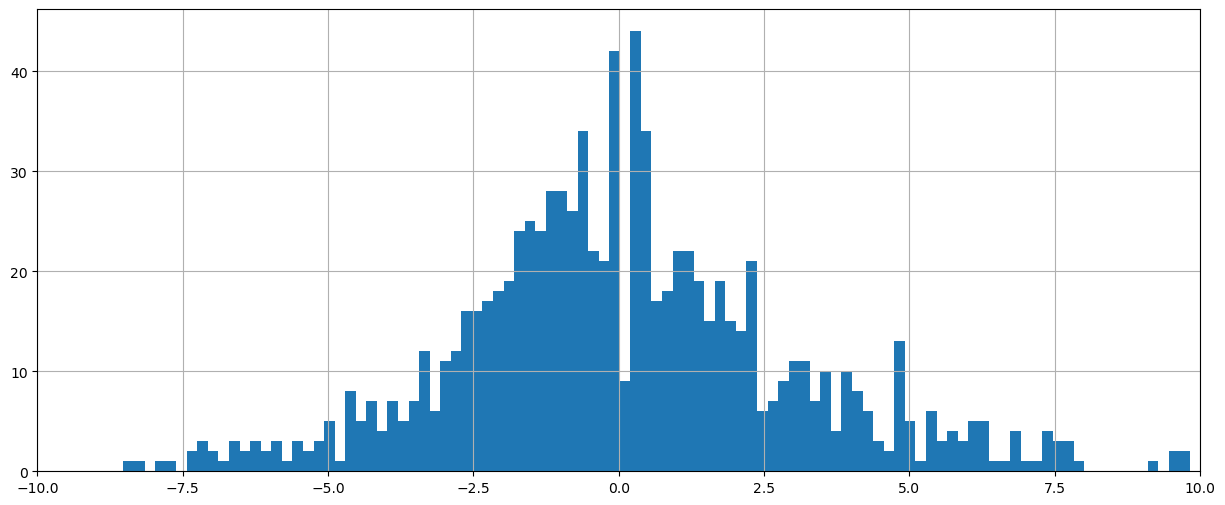

In [42]:
# 하이브 일별 로그수익률 히스토그램

fig, ax = plt.subplots(figsize = (15, 6))
ax.hist(r, bins = 200)
ax.grid(True)
ax.set_xlim((-10, 10))
plt.show()

## 최근 1년 거래내역 중 주가가 오른 비율

In [58]:
# 최근 1년 거래내역 추출

hybe_year = hybe_df.loc['2023-10-01':'2024-09-30']
df1 = hybe_year.copy()
df1['ret'] = (hybe_year['Close'].pct_change()) * 100 # 일별 수익률 계산
df2 = df1['ret']
r_year = df2.dropna()

In [66]:
# 1년 중 주가가 상승한 비율

positive = 0
n = len(r_year) # 1년 중 거래 일수

for i in range(n):
    if r_year[i] > 0:
        positive += 1
        
p_rate = positive / n
p_rate

C:\Users\narin\AppData\Local\Temp\ipykernel_14284\1102254238.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if r_year[i] > 0:


0.4628099173553719

최근 1년 하이브 거래내역 중 주가가 오른 비율은 약 46.28%이다.

## 해당 주식이 10일 중 7일 오를 확률
X ~ B(10, p_rate)  
X(P = 7) = (10! / 7!3!) * (p_rate\*\*7) * ((1-p_rate)**3)

In [70]:
import math

a = math.factorial(10)
b = math.factorial(7) * math.factorial(3)
c = (p_rate**7) * ((1-p_rate)**3)
prob = (a/b) * c
prob

0.08460261790438882

하이브 주식이 10일 중 7일 오를 확률은 약 8.46%이다.

## 해당 주식이 1년 중 며칠 오르는지와 그 변동성

In [77]:
# 최근 1년 중 주가가 상승한 일수
positive

112

In [82]:
# 최근 1년 거래 일수
n

242

In [79]:
# 확률오차
se = np.sqrt(n * p_rate * (1-p_rate))
se

7.756628730073288

하이브 주식은 1년 거래일 242일 중 112일을 주변으로 약 8일 전후로 오른다.

## 해당 주식이 1년 중 몇 % 오르는지와 그 변동성

In [89]:
# 최근 1년 중 주가가 상승한 비율
p_rate * 100

46.28099173553719

In [93]:
# 확률오차
se2 = np.sqrt(p_rate * (1-p_rate)) / np.sqrt(n)
se2 * 100

3.2052184835013584

하이브 주식은 1년 중 46.28%를 주변으로 약 3.2% 전후로 오른다.

## 해당 주식을 125일 동안 투자할 경우 예상 수익률 분포

In [121]:
# 로그수익률

hybe_df['ret'] = (np.log(hybe_df.Close) - np.log(hybe_df.Close.shift(1)))
df1 = hybe_df.dropna()
hybe_ret = df1['ret']

In [123]:
# 부트스트랩

sum_boots = []

days = 125 # 거래일 수
n = 1000 # 반복시행 수

for i in range(n):
    sample = np.random.choice(hybe_ret, size = days, replace = True)
    sample_sum = sample.sum()
    sum_boots.append(sample_sum)
len(sum_boots)

1000

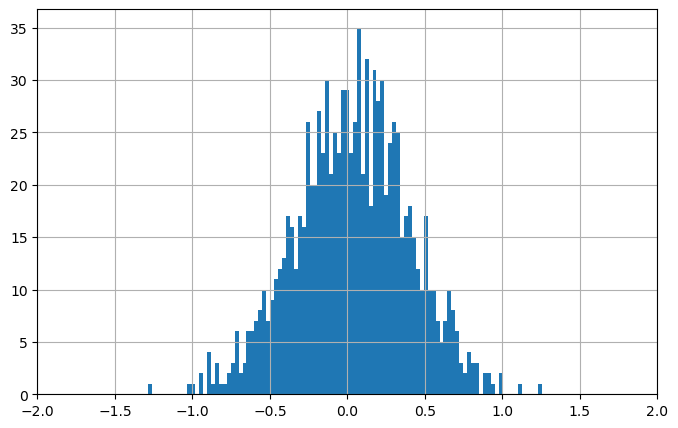

In [125]:
# 로그수익률 히스토그램

fig, ax = plt.subplots(figsize = (8, 5))
ax.hist(sum_boots, bins = 100)
ax.grid(True)
ax.set_xlim((-2, 2))
plt.show()

## 2억으로 해당 주식을 125일 거래할 경우 95% VaR로 계산한 최대 손실액

In [129]:
ret = np.array(sum_boots)
ret5 = np.percentile(ret, 5) # 하위 5% 로그수익률
hybe_ret5 = np.exp(ret5) - 1 # 일반수익률로 변환
hybe_ret5

-0.43578962869789406

In [131]:
VaR95 = hybe_ret5 * 200000000
VaR95

-87157925.73957881

2억으로 하이브 주식을 125일 거래할 경우 95% VaR로 계산한 최대 손실액은 약 8700만원이다.